In [1]:
import sys
sys.path.append('../..')

import eeg_decoder 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pandas as pd
import scipy.stats as sista
import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pingouin

import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"

np.random.seed(42)
%load_ext autoreload
%autoreload 2

C:\Users\William\AppData\Roaming\Python\Python38\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
C:\Users\William\AppData\Roaming\Python\Python38\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
experiment_name = 'd01' 
data_dir = f'./data/{experiment_name}'
exp = eeg_decoder.Experiment(experiment_name,data_dir,dev=False)

In [3]:
output_dir = Path('./output')
fig_dir = output_dir / 'figures' / 'behavior'

behavior = None
experiment_name = 'd01' 
data_dir = f'./data/{experiment_name}'
exp = eeg_decoder.Experiment(experiment_name,data_dir,dev=False)
    
for isub in range(exp.nsub):
    # Load subject's behavior data
    if behavior is None:
        behavior = pd.DataFrame(exp.load_behavior(isub))[['Subject','Condition','Error','RT']]
    else:
        temp = pd.DataFrame(exp.load_behavior(isub))[['Subject','Condition','Error','RT']]
        behavior = behavior.append(temp)

behavior.tail()

,Subject,Condition,Error,RT
1044,30,ss1_sim,-9,3.211873
1045,30,ss1_sim,-17,2.253225
1046,30,ss1_sim,1,3.128438
1047,30,ss1_sim,8,2.836036
1048,30,ss1_sim,-1,2.420478


In [4]:
behavior['AbsError'] = abs(behavior.Error)

In [5]:
total_means = behavior.groupby(['Condition'])['AbsError'].agg(['mean','std'])
subject_means = behavior.groupby(['Condition','Subject'])['AbsError'].mean().reset_index()
total_means

,mean,std
Condition,,
ss1_dis,14.784524,15.264233
ss1_sim,14.964255,15.100586
ss1_vdis,14.279689,13.006317
ss2,19.971355,24.674704


In [6]:
e_means = subject_means.query('Subject==14').reset_index(drop=True)
e_means = e_means['AbsError'].to_numpy()

In [7]:
subject_means

,Condition,Subject,AbsError
0,ss1_dis,4,16.473913
1,ss1_dis,6,11.756184
2,ss1_dis,7,15.727273
3,ss1_dis,8,12.405405
4,ss1_dis,9,10.615658
...,...,...,...
91,ss2,26,19.534091
92,ss2,27,15.920705
93,ss2,28,12.560440
94,ss2,29,21.992701


In [8]:
def get_error(query):
    return subject_means.query(query).groupby('Subject').mean().reset_index()['AbsError']

In [9]:
pingouin.ttest(get_error('Condition!="ss2"'),get_error('Condition=="ss2"'),paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-6.292446,23,two-sided,0.000002,"[-7.21, -3.64]",1.253805,9365.925,0.999954


In [10]:
get_error('Condition!="ss2"').agg(['mean','std'])

mean    14.728123
std      2.778227
Name: AbsError, dtype: float64

In [11]:
pingouin.ttest(get_error('Condition=="ss1_vdis"'),get_error('Condition=="ss1_dis"'),paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.976855,23,two-sided,0.338804,"[-1.69, 0.6]",0.178457,0.329,0.133548


In [12]:
pingouin.ttest(get_error('Condition=="ss1_vdis"'),get_error('Condition=="ss1_sim"'),paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.4623,23,two-sided,0.15719,"[-1.49, 0.26]",0.224762,0.548,0.18417


In [13]:
pingouin.ttest(get_error('Condition=="ss1_dis"'),get_error('Condition=="ss1_sim"'),paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.270577,23,two-sided,0.78913,"[-0.65, 0.5]",0.022816,0.222,0.051317


In [29]:
total_mean_vals = total_means.reset_index()['mean']

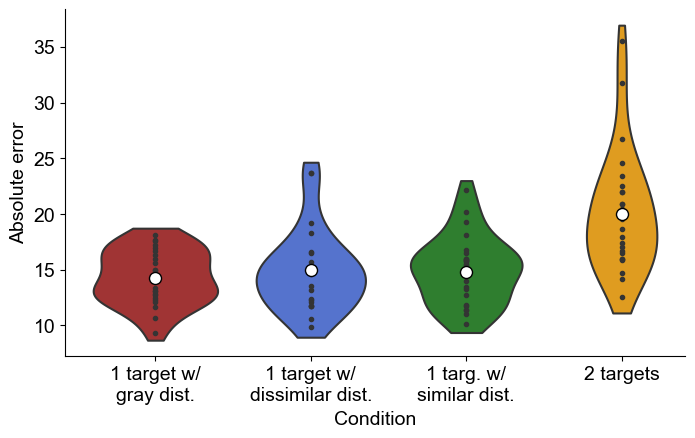

In [33]:
fig, ax = plt.subplots(1, 1, sharey=True, figsize=(8,4.5))
my_pal = {"royalblue", "firebrick", "forestgreen", "orange"}

# experiment 1
sns.violinplot(
    ax = ax, 
    x='Condition',y='AbsError', 
    order = ['ss1_vdis','ss1_dis','ss1_sim','ss2'],
    data=subject_means,
    dodge=True,inner='points',cut=.5,palette = my_pal,)

ax = plt.gca()
# plot means
ax.scatter(
    x = [0,1,2,3],
    y = [total_mean_vals[2],total_mean_vals[1],total_mean_vals[0],total_mean_vals[3]],
    c = 'white', edgecolors='k',s=75)

# asethetics
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)
ax.set_xlabel('Condition',fontsize=14)
ax.set_ylabel('Absolute error',fontsize=14)
ax.set_xticklabels(['1 target w/\ngray dist.','1 target w/\ndissimilar dist.','1 targ. w/\nsimilar dist.','2 targets'])
# plt.ylim([.46,1.04])
plt.savefig('output/figures/cd_accuracy.png',dpi=500,bbox_inches='tight')
plt.savefig('output/figures/cd_accuracy.pdf',dpi=500,bbox_inches='tight')

plt.show()